# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd #импорт нужных библиотек
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [2]:
cars = pd.read_csv('/datasets/autos.csv') #чтение файла
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Признаки:

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак:

Price — цена (евро)

Данные загружены и изучены , преобразование требуется для таких признаков ,как - дата создании анкеты,дата скачивания анкеты ,регистрации,год регистрации авто,мощности авто и цены .

In [5]:
cars['DateCrawled'] = pd.to_datetime(cars['DateCrawled'], format='%Y-%m-%d %H:%M') # преобразуем дату анкеты
cars['DateCreated'] = pd.to_datetime(cars['DateCreated'], format='%Y-%m-%d %H:%M')
cars['LastSeen'] = pd.to_datetime(cars['LastSeen'], format='%Y-%m-%d %H:%M') 
#cars= cars.drop(['DateCrawled', 'DateCreated' , 'LastSeen'], axis=1)

In [6]:
cars['LastSeen'].max() #посмотрим на дату последней ативности

Timestamp('2016-04-07 14:58:51')

In [7]:
cars= cars.drop(['DateCrawled', 'DateCreated' , 'LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

In [8]:
cars.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

In [9]:
cars['Repaired'].value_counts() #посмотрим на значения 

no     247161
yes     36054
Name: Repaired, dtype: int64

In [10]:
cars['Repaired'].fillna('no').copy() #заполним пропуски , предположим что 0 - машина не была в ремонте 

0          no
1         yes
2          no
3          no
4          no
         ... 
354364    yes
354365     no
354366     no
354367     no
354368     no
Name: Repaired, Length: 354369, dtype: object

In [11]:
cars['Gearbox'].value_counts()
cars['Gearbox'].fillna('manual').copy()

0         manual
1         manual
2           auto
3         manual
4         manual
           ...  
354364    manual
354365    manual
354366      auto
354367    manual
354368    manual
Name: Gearbox, Length: 354369, dtype: object

In [12]:
def boxplot_print(colum, bins): #функция для построения диаграммы размаха
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    sns.boxplot(x=colum, color='blue')   
    plt.show()

Проанализируем выбросы и аномалии в признаках и избавимся от них. 

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


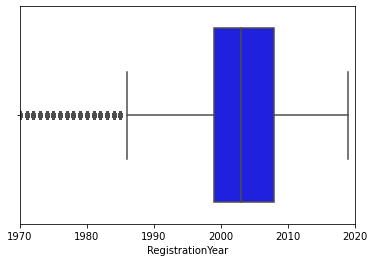

In [13]:
plt.xlim(1970, 2020) 
boxplot_print(cars['RegistrationYear'], 10)

In [14]:
cars=cars.loc[cars['RegistrationYear']>=1980]
cars=cars.loc[cars['RegistrationYear']<=2016]

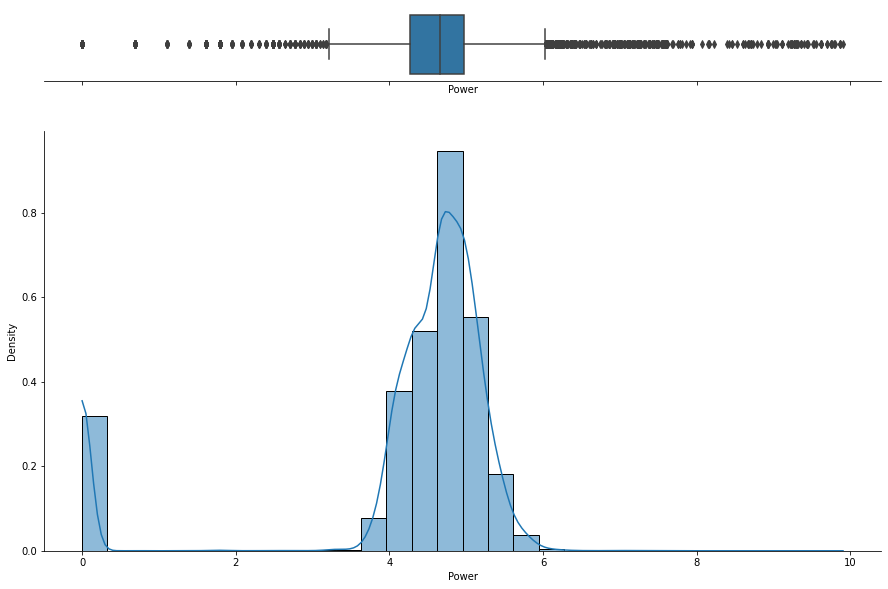

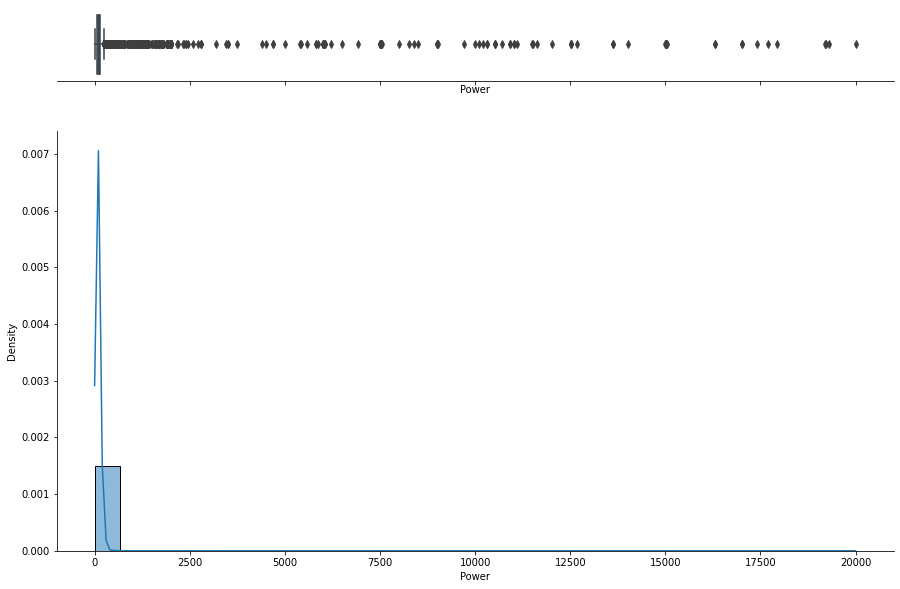

In [15]:
#КОД РЕВЬЮЕРА
def hist_and_box_plot(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,10))

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=30, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    
df_primer = cars.copy()
hist_and_box_plot(np.log1p(df_primer['Power']))
hist_and_box_plot(df_primer['Power'])

In [16]:
cars.loc[(cars['Power'] > 1000) | (cars['Power'] <= 0), 'Power'] = None
cars['Power'] = cars['Power'].fillna(cars.groupby('Model')['Power'].transform('median'))
cars=cars.loc[~cars['Power'].isna()]

count    331161.000000
mean        119.629135
std          53.682631
min           1.000000
25%          75.000000
50%         110.000000
75%         147.000000
max        1000.000000
Name: Power, dtype: float64


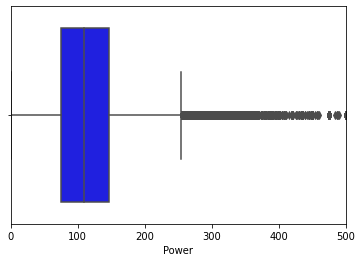

In [17]:
plt.xlim(0,500)
boxplot_print(cars['Power'], 10)

In [18]:
cars=cars.loc[cars['Price'] != 0]

In [19]:
cars=cars.loc[cars.loc[:,'Price'] > 100]
cars=cars.loc[cars.loc[:,'Price'] <= 20000]

count    319543.000000
mean       4655.730963
std        4534.297865
min         101.000000
25%        1250.000000
50%        2990.000000
75%        6700.000000
max       20000.000000
Name: Price, dtype: float64


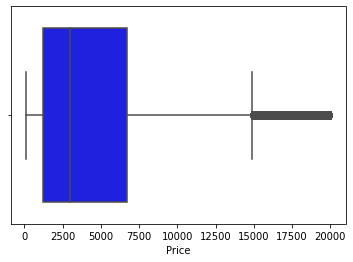

In [20]:
boxplot_print(cars['Price'],10)

In [21]:
cars=cars.drop_duplicates()#удалим дубликаты

In [22]:
cars.isna().sum()

Price                    0
VehicleType          15970
RegistrationYear         0
Gearbox              11027
Power                    0
Model                10180
Kilometer                0
RegistrationMonth        0
FuelType             19842
Brand                    0
Repaired             51364
dtype: int64

Все пропуски занимают меньше одного процента от исходных данных и находятся в категориальных переменных заполним'n/n'

In [23]:
cars.fillna('n/a',inplace=True)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294208 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              294208 non-null  int64  
 1   VehicleType        294208 non-null  object 
 2   RegistrationYear   294208 non-null  int64  
 3   Gearbox            294208 non-null  object 
 4   Power              294208 non-null  float64
 5   Model              294208 non-null  object 
 6   Kilometer          294208 non-null  int64  
 7   RegistrationMonth  294208 non-null  int64  
 8   FuelType           294208 non-null  object 
 9   Brand              294208 non-null  object 
 10  Repaired           294208 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.9+ MB


In [26]:
target = cars['Price']
features = cars.drop(['Price'], axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((235366, 10), (58842, 10), (235366,), (58842,))

In [28]:
cars

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,n/a,1993,manual,101.0,golf,150000,0,petrol,volkswagen,n/a
1,18300,coupe,2011,manual,190.0,n/a,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,n/a
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,n/a,2016,auto,150.0,159,150000,12,n/a,alfa_romeo,no
354362,3200,sedan,2004,manual,225.0,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no


Данные преобразованы , аномалии очищены , выборки подготовлены .

## Обучение моделей

In [29]:
kf = KFold(n_splits=3, shuffle=True, random_state=12345) #разобьем на подвыборки
test_s = {}

In [30]:
cars

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,n/a,1993,manual,101.0,golf,150000,0,petrol,volkswagen,n/a
1,18300,coupe,2011,manual,190.0,n/a,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,n/a
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,n/a,2016,auto,150.0,159,150000,12,n/a,alfa_romeo,no
354362,3200,sedan,2004,manual,225.0,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no


In [31]:
categories=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numerics=['Power', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']

In [32]:
col_transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerics),
                                                  ('ohe', OneHotEncoder(sparse=False, drop='first'), categories)],
                                                   remainder='passthrough')

transform_train = col_transformer.fit_transform(X_train)
transform_test = col_transformer.transform(X_test)

Линейная регрессия

In [33]:
linear_model = LinearRegression()
result = cross_validate(linear_model,
                           transform_train,
                           y_train,
                           cv=5,
                           scoring='neg_root_mean_squared_error')

fit_time = result['fit_time'].mean()
score_time = result['score_time'].mean()
test_score = result['test_score'].mean() * -1

print(f'Время обучения: {fit_time},  время предсказания: {score_time} и RMSE: {test_score}')   

Время обучения: 32.660392904281615,  время предсказания: 0.10301427841186524 и RMSE: 2443.858602970932


In [34]:
test_s['LN']=[fit_time,score_time,test_score]

LidhtGBM

In [35]:
col_transformer_ordinal = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerics),
                     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categories)],
                                                   remainder='passthrough')

transform_train_ordinal = col_transformer_ordinal.fit_transform(X_train)
transform_test_ordinal = col_transformer_ordinal.transform(X_test) 

In [36]:
lgb_model = LGBMRegressor()
params = [{'learning_rate': [0.05, 0.1],'n_estimators': [100, 200],'num_leaves': [31, 62]}]

 
grid = GridSearchCV(estimator=lgb_model, param_grid=params,n_jobs=-1,scoring='neg_root_mean_squared_error',cv=kf)

grid.fit(transform_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.05, 0.1],
                          'n_estimators': [100, 200], 'num_leaves': [31, 62]}],
             scoring='neg_root_mean_squared_error')

In [37]:
results = grid.cv_results_

In [38]:
best_index = grid.best_index_

fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = abs(grid.best_score_)

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")    

Fit time: 15.756566445032755, Predict time: 1.3784135182698567, Best RMSE: 1550.2155926056182


In [39]:
test_s['LGB']=[fit_time,score_time,test_score]

fOREST

In [41]:
col_transformer_ordinal = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerics),
                     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categories)],
                                                   remainder='passthrough')

transform_train_ordinal = col_transformer_ordinal.fit_transform(X_train)
transform_test_ordinal = col_transformer_ordinal.transform(X_test)    

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
forest_params = {
    'max_depth': [11, 12, 13],
    'n_estimators': [100, 200, 300]
}

     

grid_rfr = GridSearchCV(RandomForestRegressor(random_state=42), 
                        forest_params, refit=False, cv=kf, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_rfr.fit(transform_train_ordinal, y_train)

{'max_depth': 13, 'n_estimators': 300}

In [46]:
results = grid_rfr.cv_results_

In [47]:
best_index = grid_rfr.best_index_

fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = abs(grid.best_score_)

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")    

Fit time: 77.89232611656189, Predict time: 2.859623908996582, Best RMSE: 1550.2155926056182


In [48]:
test_s['FOREST']=[fit_time,score_time,test_score]

## Анализ моделей

In [51]:
df_score = pd.DataFrame.from_dict(data=test_s, columns=['fit_time', 'score_time', 'test_score'], orient='index')
df_score

,fit_time,score_time,test_score
LN,32.660393,0.103014,2443.858603
LGB,15.756566,1.378414,2443.858603
FOREST,77.892326,2.859624,2443.858603


В ходе работы обучили 3 модели такие как LinearRegression,LGBMRegressor,ForestRegressor

Модель LGBMRegressor показала наилучший результат по качеству так и по времени.